In [1]:
import pandas as pd
import os
import glob
import requests
from datetime import datetime

In [2]:
rtd_loc = r"..\data\readthedocs"
pypi_loc = r"..\data\pypistats"

# Files from https://readthedocs.org/dashboard/openpolicedata/traffic-analytics/
files = glob.glob(os.path.join(rtd_loc, "readthedocs_traffic_analytics_openpolicedata_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="Date"))


df = pd.concat(csvs, ignore_index=True)
df = df.drop_duplicates(subset=["Date","Version","Path"], keep='last').sort_values(by="Date", ignore_index=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df = df[(df['Version']=='stable') | df['Version'].str.startswith('v')]
df.head()

,Version,Path,Views
Date,,,
2023-09-17,stable,/index.html,5
2023-09-18,stable,/index.html,8
2023-09-18,stable,/documentation.html,2
2023-09-18,v0.5.7,/index.html,1
2023-09-19,stable,/index.html,3


In [3]:
df_index = df[df['Path']=='/index.html'].copy()
df_index = df_index.resample("1D").sum()
df_index['Views Filtered'] = df_index['Views'].rolling(window='7D', center=True).mean()
df_index.head()

,Version,Path,Views,Views Filtered
Date,,,,
2023-09-17,stable,/index.html,5,4.500000
2023-09-18,stablev0.5.7,/index.html/index.html,9,3.600000
2023-09-19,stable,/index.html,3,3.000000
2023-09-20,stable,/index.html,1,2.571429
2023-09-21,0,0,0,2.000000


<Axes: xlabel='Date'>

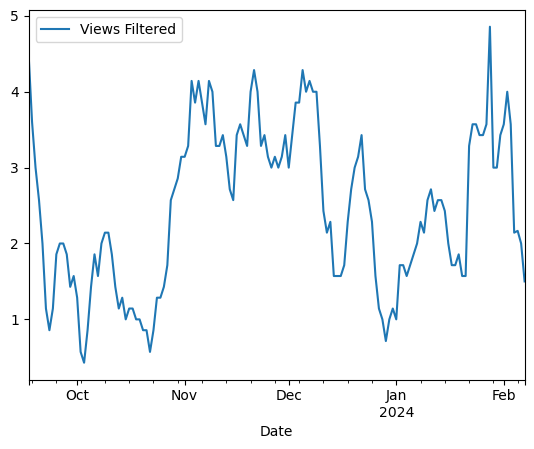

In [4]:
df_index.plot.line(y="Views Filtered")

In [5]:
# Update pypi stats
pypi = 'https://pypistats.org/api/'
r = requests.get(pypi+"packages/openpolicedata/overall", params={'mirrors':False})
r.raise_for_status()
data = r.json()

pypi_df = pd.DataFrame(data['data'])
filename = os.path.join(pypi_loc, "pypistats_"+ datetime.now().strftime("%Y%m%d")+".csv")
if not os.path.exists(filename):
    pypi_df.to_csv(filename, index=False)

In [6]:
files = glob.glob(os.path.join(pypi_loc, "pypistats_*.csv"))

csvs = []
for f in files:
    csvs.append(pd.read_csv(f).sort_values(by="date"))

df_pypi = pd.concat(csvs, ignore_index=True)
df_pypi["date"] = pd.to_datetime(df_pypi["date"])
df_pypi = df_pypi[df_pypi['date']>df.index.min()]
df_pypi=df_pypi[df_pypi['category']=='without_mirrors']
df_pypi = df_pypi.drop_duplicates(subset=["date"], keep='last').sort_values(by="date", ignore_index=True)
df_pypi = df_pypi.set_index('date')
df_pypi = df_pypi.resample("1D").sum()
df_pypi['Downloads Filtered'] = df_pypi['downloads'].rolling(window='7D', center=True).mean()
df_pypi.tail(5)

,category,downloads,Downloads Filtered
date,,,
2024-02-04,without_mirrors,6,7.142857
2024-02-05,without_mirrors,28,6.428571
2024-02-06,0,0,6.833333
2024-02-07,without_mirrors,1,7.800000
2024-02-08,without_mirrors,4,8.250000


<Axes: xlabel='date'>

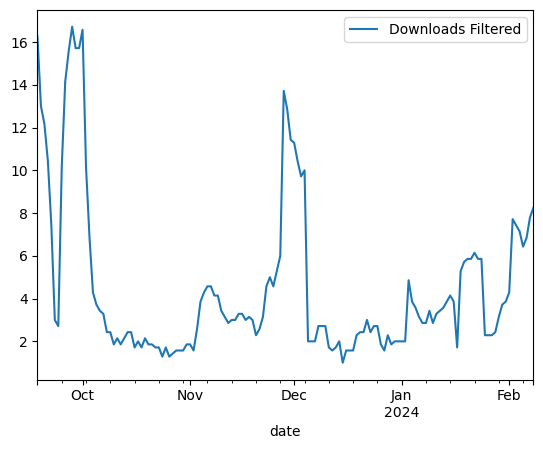

In [7]:
df_pypi.plot.line(y="Downloads Filtered")

<Axes: xlabel='date'>

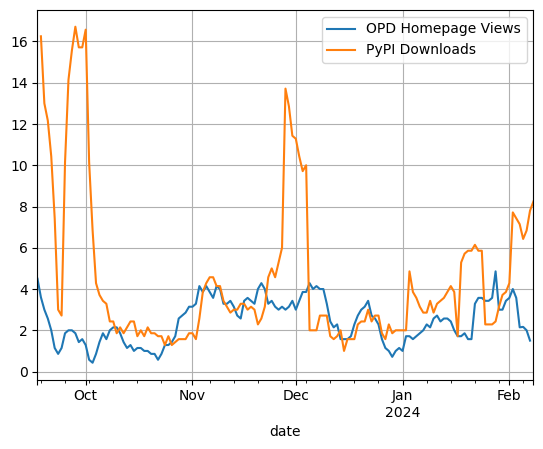

In [8]:
# fig, axes = plt.subplots(nrows=2, ncols=1)

# df_index.plot.line(y="Views Filtered", ax=axes[0], title="OPD Homepage Views", grid=True)
# df_pypi.plot.line(y="Downloads Filtered", ax=axes[1], title="PyPI Downloads", grid=True)

ax = df_index.plot.line(y="Views Filtered", label="OPD Homepage Views", grid=True)
df_pypi.plot.line(y="Downloads Filtered", ax=ax, label="PyPI Downloads", grid=True)